# Extended Kalman Filter Implementation for State Estimation

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
from celluloid import Camera
from sympy import Symbol, symbols, Matrix, sqrt, atan2
from sympy import init_printing
import math
from sklearn.metrics import mean_squared_error as mse
init_printing(use_latex=True)

## Visualize True States - Scenario Simulation

In [3]:
# Define initial positions (x, y) in m:
pos_egoCar = (0, 0)
pos_actor1 = (-2, 90)
pos_actor2 = (2, 60)
pos_actor3 = (-2, -40)
pos_actor4 = (0, -10)
num_actors = 4

# Define the initial velocities (y-axis) in m/s:
vel_egoCar = 20
vel_actor1 = 25
vel_actor2 = 15
vel_actor3 = 35
vel_actor4 = 15

pos_list = [pos_egoCar, pos_actor1, pos_actor2, pos_actor3, pos_actor4]
vel_list = [vel_egoCar, vel_actor1, vel_actor2, vel_actor3, vel_actor4]
ego_positions = [] #position of the ego car in the entire simulation time frame
true_states_alltimes = [] #state vectors (x,vel_x, y, vel_y) of all cars for each time step
simulation_duration = 96
dt = 1/3

def get_state(initial_pos, vel, t):
    '''
    x = x_0 + v_i*t
    '''
    state = np.zeros((4,1))
    state[0] = initial_pos[0]
    state[1] = 0
    state[2] = initial_pos[1] + vel * t
    state[3] = vel
    return state

def display_true_states(pos_list, vel_list, simulation_duration, dt):
    sns.set_style("white")
    my_dpi=96
    camera = Camera(plt.figure(figsize=(480/my_dpi, 600/my_dpi), dpi=my_dpi))
    cols = ['green', 'red', 'blue', 'black', 'orange']
    for t in range(0, simulation_duration, 1):
        true_state_at_time = []
        plt.axvline(1, linestyle='--', color='grey')
        plt.axvline(-1, linestyle='--', color='grey')
        for idx, (pos, vel) in enumerate(zip(pos_list, vel_list)):
            state = get_state(pos, vel, dt * t)
            plt.scatter(state[0,0], state[2,0], color=cols[idx], alpha=0.5, 
                        edgecolors="grey", linewidth=2)
            true_state_at_time.append(state)
            if idx == 0:
                ego_positions.append(np.array([state[0], state[2]]))

        true_states_alltimes.append(true_state_at_time)
        camera.snap()

    anim = camera.animate(blit=True)
    anim.save('true_states.mp4')

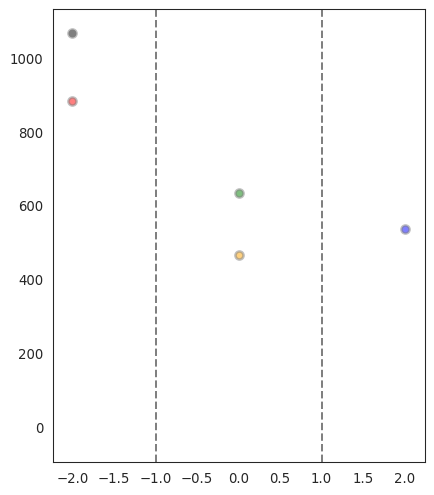

In [4]:
display_true_states(pos_list, vel_list, simulation_duration, dt)

## Dynamic Process and EKF Modeling

In [5]:
# y-axis in the coordinate reference frame of the ego is the x-axis in scenario, and vice versa.
x, y, rad, theta, time_step, vel_x, vel_y = symbols('x y r \Theta T \dot{x} \dot{y}')

# u1 and u2 are random samples drawn from N(0, var_{a}) representing an unknown acceleration.
var_acc = 0.01
u1 = np.random.normal(0, var_acc)
u2 = np.random.normal(0, var_acc)

F = Matrix([[x + vel_x*time_step],
            [vel_x + u1],
            [y + vel_y*time_step],
            [vel_y + u2]])
state = Matrix([x, vel_x, y, vel_y])

## State

In [6]:
state

## State Transition Matrix

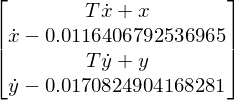

In [7]:
F

## Jacobian of the State Transition Matrix

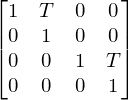

In [8]:
# Point-wise linear approximation of the function f near the each variable in the state vector
F.jacobian(state)

## Observations

In [9]:
# For observations, consider using sensors that operate on polar coordinates yielding radius and angle
Z = Matrix([[rad],
            [theta]])
Z

## Observation Matrix

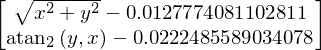

In [10]:
# representing noises on the measured distance and direction
var_dist = 1
var_dir = 0.1
n1 = np.random.normal(0,var_dist)
n2 = np.random.normal(0,var_dir)

H = Matrix([[sqrt(x**2+y**2) + n1],
            [atan2(y, x) + n2]])
H

## Jacobian of the Observation Matrix

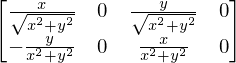

In [11]:
# Point-wise linear approximation of the function f near the each variable in the state vector
H.jacobian(state)

## Process Noise Covariance Matrix

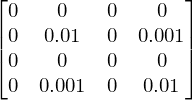

In [12]:
# small number allows for some covariance in practice
small_num = 1e-3
Q = Matrix([[0, 0, 0, 0],
            [0, var_acc, 0, small_num],
            [0, 0, 0, 0],
            [0, small_num, 0, var_acc]])
Q

## Measurement Noise Covariance Matrix

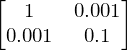

In [13]:
R = Matrix([[var_dist, small_num],
            [small_num, var_dir]])
R

## Generate Measurements and Display Scenario

In [14]:
measurement_list_alltimes = []
for t in range(0, simulation_duration, 1):
    measurement_list_at_time = []
    for idx, (pos, vel) in enumerate(zip(pos_list[1:], vel_list[1:])): #generate for meas. for actors
        noise_x = np.random.normal(0,0.1)
        noise_y = np.random.normal(0,2)
        state = get_state(pos, vel, dt * t)
        meas_x = state[0] + noise_x
        meas_y = state[2] + noise_y
        measurement_list_at_time.append(np.array([meas_x, meas_y]))
    
    measurement_list_alltimes.append(measurement_list_at_time)

def display_measurements(pos_list, vel_list, measurement_list_alltimes):
    sns.set_style("white")
    my_dpi=96
    camera = Camera(plt.figure(figsize=(480/my_dpi, 600/my_dpi), dpi=my_dpi))
    cols = ['green', 'red', 'blue', 'black', 'orange']
    for t in range(0, simulation_duration, 1):
        plt.axvline(1, linestyle='--', color='grey')
        plt.axvline(-1, linestyle='--', color='grey')
        for idx, (pos, vel) in enumerate(zip(pos_list, vel_list)):
            plt.scatter(true_states_alltimes[t][idx][0], 
                        true_states_alltimes[t][idx][2], 
                        color=cols[idx], alpha=0.5, edgecolors="grey", linewidth=2)
            if idx != 0: #not ego
                meas_x = measurement_list_alltimes[t][idx-1][0]
                meas_y = measurement_list_alltimes[t][idx-1][1]
                plt.scatter(meas_x, meas_y, facecolors='none', edgecolors='r')

        camera.snap()

    anim = camera.animate(blit=True)
    anim.save('measurements.mp4')

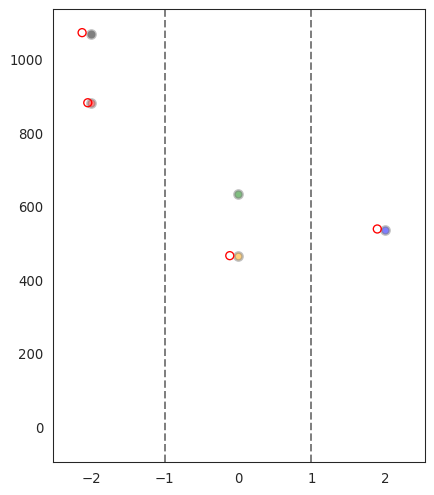

In [15]:
display_measurements(pos_list, vel_list, measurement_list_alltimes)

## Hyperparameter Selection

In [16]:
J_f = np.array([[1, dt, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, dt],
                [0, 0, 0, 1]])

Q = np.array([[0, 0, 0, 0],
              [0, var_acc, 0, small_num],
              [0, 0, 0, 0],
              [0, small_num, 0, var_acc]]) 

R = np.array([[var_dist, small_num],
              [small_num, var_dir]]) 

# The derivative of the state transition equations with respect to the dynamic noises u1 and u2
df_da = np.array([[0, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1]])

# The derivative of the observation equations with respect to the measurement noises
dh_dn = np.array([[1, 0],
                  [0, 1]])

# initialize state and error covariance
state = np.zeros((4,1))
error_covariance = np.identity(4)*1000
kalman_gain = np.zeros((4,2))

## EKF Tracker

In [17]:
state_estimates_alltimes = [] 
error_covariance_alltimes = []
kalman_gain_alltimes = []

for t, measurement_at_time in enumerate(measurement_list_alltimes):
    state_estimates_at_time = []
    error_covariance_at_time = []
    kalman_gain_at_time = []
    for idx, measurements in enumerate(measurement_at_time):
        # provide measurements in polar coordinates to the vehicle wrt its coordinate frame
        # car's x-axis is the y-axis in global coordinate frame and vice versa.
        relative_pos_x = measurements[1] - ego_positions[t][1]
        relative_pos_y = measurements[0] - ego_positions[t][0]
        rad = math.sqrt(relative_pos_x**2 + relative_pos_y**2)
        theta = math.atan2(relative_pos_y, relative_pos_x)
        
        # TIME UPDATE
        if t != 0:
            pos_estimate_x = state_estimates_alltimes[-1][idx][0,0]
            vel_estimate_x = state_estimates_alltimes[-1][idx][1,0]
            pos_estimate_y = state_estimates_alltimes[-1][idx][2,0]
            vel_estimate_y = state_estimates_alltimes[-1][idx][3,0]
            
            # Apply state transition equations
            u1 = np.random.normal(0, var_acc)
            u2 = np.random.normal(0, var_acc)
            state[0,0] = pos_estimate_x + vel_estimate_x * dt
            state[1,0] = vel_estimate_x + u1
            state[2,0] = pos_estimate_y + vel_estimate_y * dt
            state[3,0] = vel_estimate_y + u2
            
            error_covariance = J_f @ error_covariance_alltimes[-1][idx] @ J_f.T + df_da * Q *df_da.T

            # MEASUREMENT UPDATE
            J_h = np.array([[state[0,0] * np.sqrt((state[0,0]**2 + state[2,0]**2)), 0,
                             state[2,0] * np.sqrt((state[0,0]**2 + state[2,0]**2)), 0], 
                            [-state[2,0] / (state[0,0]**2 + state[2,0]**2), 0,
                             state[0,0] / (state[0,0]**2 + state[2,0]**2), 0]])
            
            kalman_gain = (error_covariance @ J_h.T) @ \
                           inv(J_h @ error_covariance @ J_h.T + dh_dn @ R @ dh_dn.T)
            n1 = np.random.normal(0, var_dist)
            n2 = np.random.normal(0, var_dir)
            state = state + kalman_gain @ (np.array([[rad],[theta]]) - \
                            np.array([[np.sqrt(state[0,0]**2 + state[2,0]**2) + n1],
                                      [math.atan2(state[2,0], state[0,0]) + n2]]))
            error_covariance = (np.identity(4) - (kalman_gain @ J_h)) @ error_covariance
            
        state_estimates_at_time.append(state)
        error_covariance_at_time.append(error_covariance)
        kalman_gain_at_time.append(kalman_gain)
    
    state_estimates_alltimes.append(state_estimates_at_time)
    error_covariance_alltimes.append(error_covariance_at_time)  
    kalman_gain_alltimes.append(kalman_gain_at_time)  

/home/andac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/andac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


## Filter Performance

In [18]:
def display_estimations(pos_list, vel_list, measurement_list_alltimes, state_estimates_alltimes):
    sns.set_style("white")
    my_dpi=96
    camera = Camera(plt.figure(figsize=(480/my_dpi, 600/my_dpi), dpi=my_dpi))
    cols = ['green', 'red', 'blue', 'black', 'orange']
    for t in range(0, simulation_duration, 1):
        plt.axvline(1, linestyle='--', color='grey')
        plt.axvline(-1, linestyle='--', color='grey')
        for idx, (pos, vel) in enumerate(zip(pos_list, vel_list)):
            plt.scatter(true_states_alltimes[t][idx][0], 
                        true_states_alltimes[t][idx][2],
                        color=cols[idx], alpha=0.5, edgecolors="grey", linewidth=2)
            if idx != 0: #not ego
                meas_x = measurement_list_alltimes[t][idx-1][0]
                meas_y = measurement_list_alltimes[t][idx-1][1]
                plt.scatter(meas_x, meas_y, facecolors='none', edgecolors='r')

                # add the position of the ego -> revert to the common coordinate frame
                estimate_state_x = state_estimates_alltimes[t][idx-1][2] + ego_positions[t][0]
                estimate_state_y = state_estimates_alltimes[t][idx-1][0] + ego_positions[t][1]
                plt.scatter(estimate_state_x, estimate_state_y, facecolors='none', edgecolors='b')

        camera.snap()

    anim = camera.animate(blit=True)
    anim.save('state_estimations.mp4')

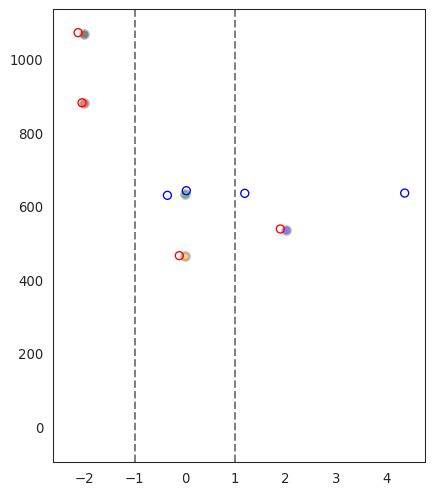

In [19]:
display_estimations(pos_list, vel_list, measurement_list_alltimes, state_estimates_alltimes)

## Filter Performance - 2

In [20]:
def get_mse():
    position_mse_alltimes = []
    velocity_mse_alltimes = []
    pos_indices, vel_indices = [0, 2], [1, 3]
    
    # iter for each time step
    for t, (ts, se) in enumerate(zip(true_states_alltimes, state_estimates_alltimes)):
        position_mse_at_time = []
        velocity_mse_at_time = []
        # iter for each actor that exists in the scenario
        for idx in range(len(se)):
            position_mse_at_time.append(mse(list(ts[idx][pos_indices]), list(se[idx][pos_indices])))
            velocity_mse_at_time.append(mse(list(ts[idx][vel_indices]), list(se[idx][vel_indices])))
            
        position_mse_alltimes.append(position_mse_at_time)
        velocity_mse_alltimes.append(velocity_mse_at_time)
    
    return position_mse_alltimes, velocity_mse_alltimes
  

In [21]:
def plot_performance(position_mse_alltimes, velocity_mse_alltimes):
    t = np.arange(0, len(position_mse_alltimes), 1)
    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(32,24))
 
    ax1.set_title('MSE Between True Positions and EKF Estimated Positions', fontsize=36)
    ax1.plot(t, [item[0] for item in position_mse_alltimes], 'r', label='actor 1')
    ax1.plot(t, [item[1] for item in position_mse_alltimes], 'b', label='actor 2')
    ax1.plot(t, [item[2] for item in position_mse_alltimes], 'g', label='actor 3')
    ax1.plot(t, [item[3] for item in position_mse_alltimes], 'black', label='actor 4')
    legend = ax1.legend(loc='upper left', fontsize=24)
    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('white')   
    ax1.set_xticks(np.arange(min(t), max(t)+1, 10))
    ax1.tick_params(axis='both', which='major', labelsize=30)

    ax2.set_title('MSE Between True Velocities and EKF Estimated Velocities', fontsize=36)
    ax2.plot(t, [item[0] for item in velocity_mse_alltimes], 'r', label='actor 1')
    ax2.plot(t, [item[1] for item in velocity_mse_alltimes], 'b', label='actor 2')
    ax2.plot(t, [item[2] for item in velocity_mse_alltimes], 'g', label='actor 3')
    ax2.plot(t, [item[3] for item in velocity_mse_alltimes], 'black', label='actor 4')   
    legend = ax2.legend(loc='upper left', fontsize=24)
    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('white')    
    ax2.set_xticks(np.arange(min(t), max(t)+1, 10))
    ax2.tick_params(axis='both', which='major', labelsize=30)
    ax2.set_xlabel('Time Step', fontsize=30)

    plt.show()    

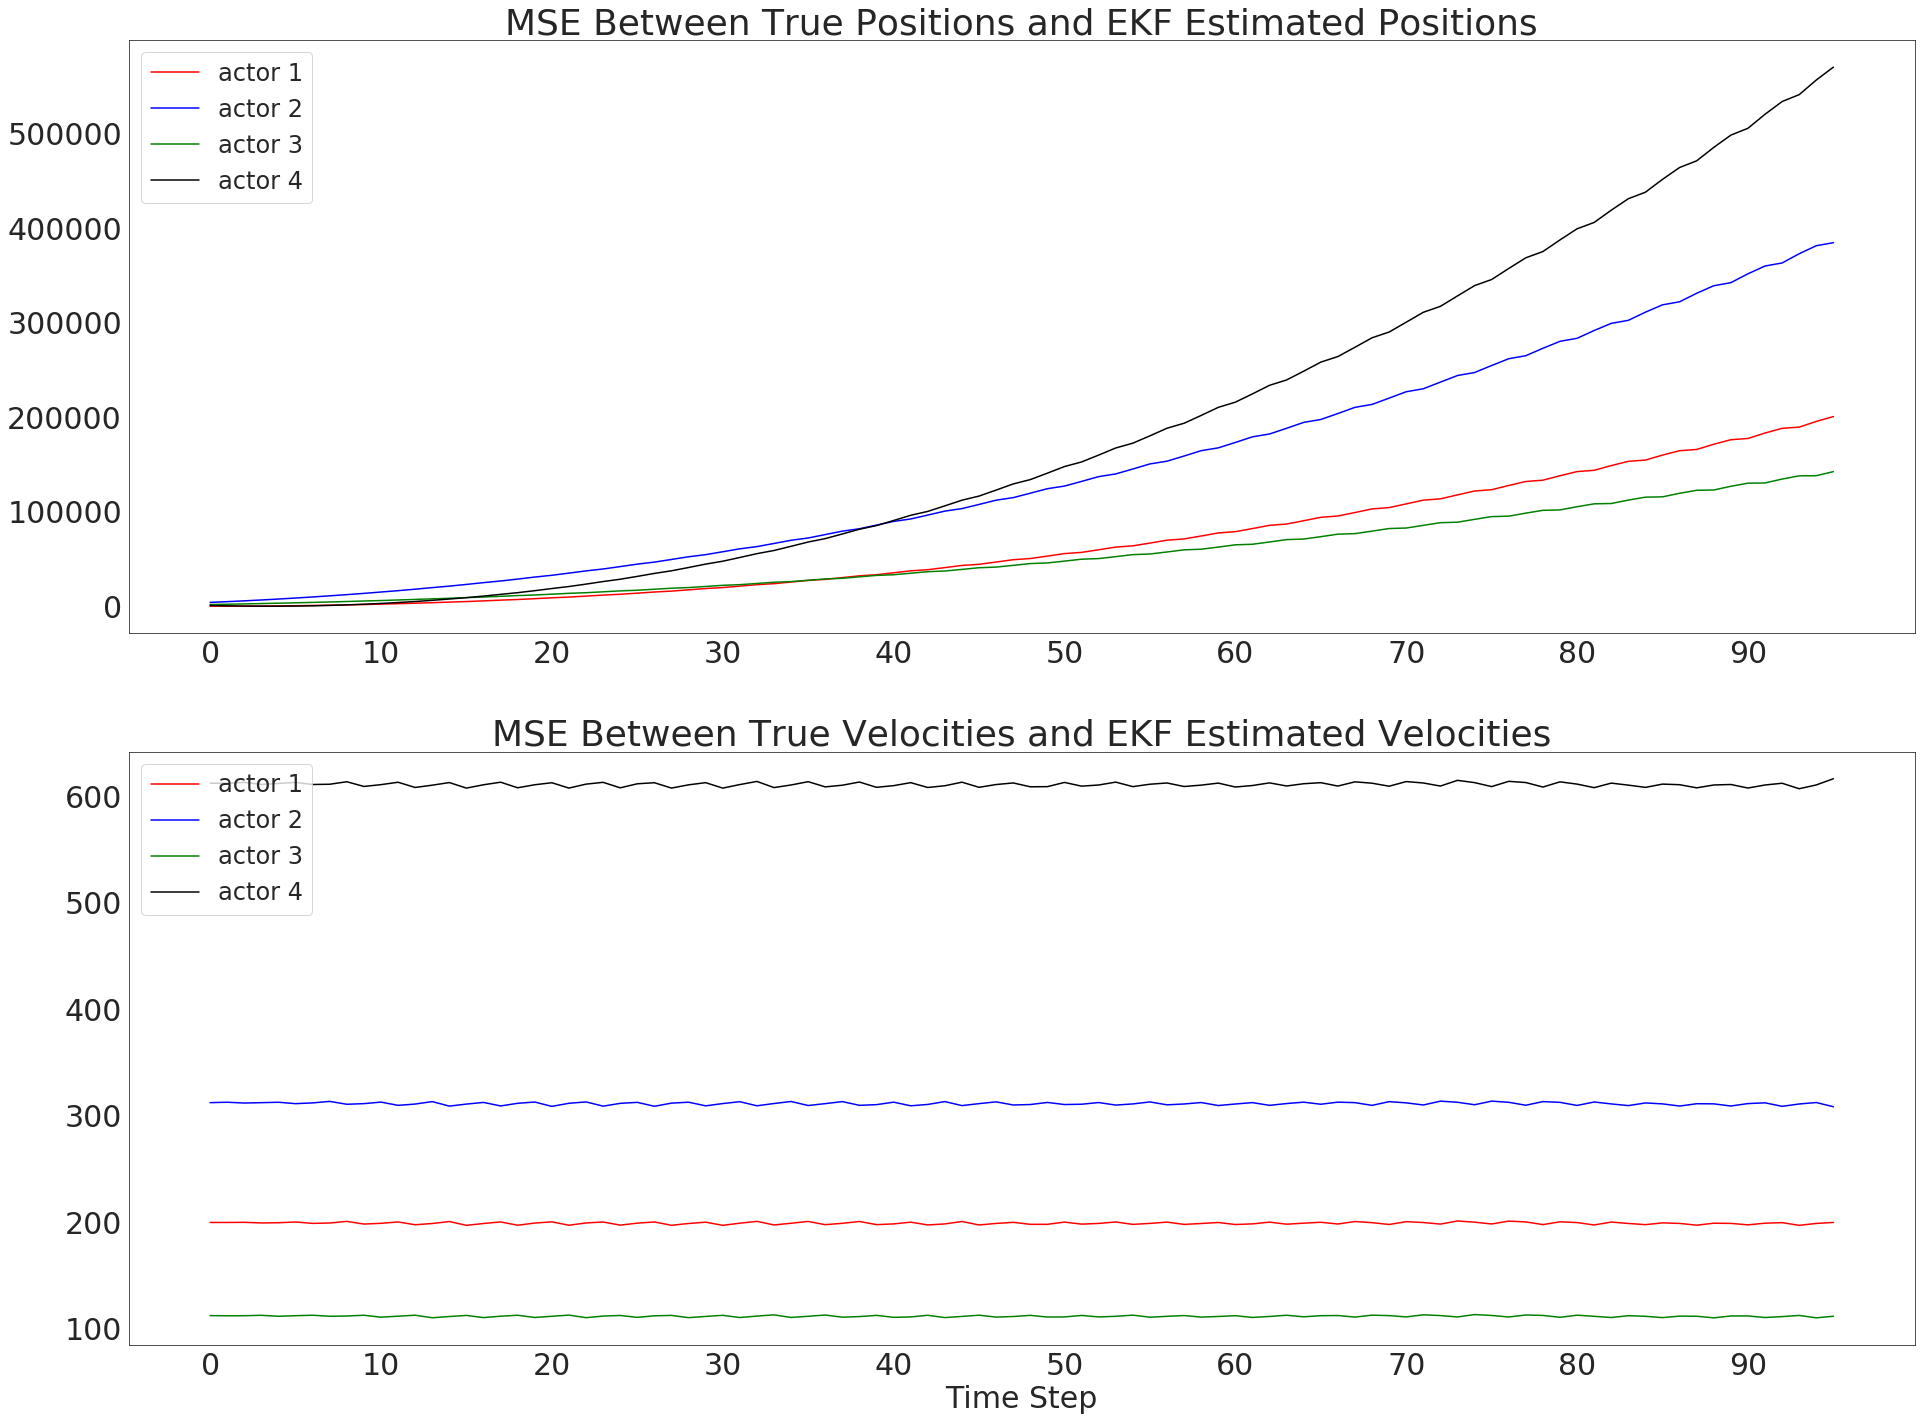

In [22]:
position_mse_alltimes, velocity_mse_alltimes = get_mse()
plot_performance(position_mse_alltimes, velocity_mse_alltimes)